In [9]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm

# Adaptive Kalman Filter Implementation for Constant Velocity Model (CV) in Python

![Image](http://www.cbcity.de/wp-content/uploads/2013/06/Fahrzeug_GPS_Tunnel-520x181.jpg)

Situation covered: You drive with your car in a tunnel and the GPS signal is lost. Now the car has to determine, where it is in the tunnel. The only information it has, is the velocity in driving direction. The x and y component of the velocity ($\dot x$ and $\dot y$) can be calculated from the absolute velocity (revolutions of the wheels) and the heading of the vehicle (yaw rate sensor).

## State Vector

Constant Velocity Model for Ego Motion

$$x= \left[ \matrix{ x \\ y \\ \dot x \\ \dot y} \right]$$



Formal Definition:

$$x_{k+1} = \textbf{A} \cdot x_{k}$$

$$x_{k+1} = \begin{bmatrix}1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \cdot \begin{bmatrix} x \\ y \\ \dot x \\ \dot y \end{bmatrix}_{k}$$

$$y = \textbf{H} \cdot x$$

$$y = \begin{bmatrix}0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix} \cdot x$$

### Initial State

[[0.]
 [0.]
 [0.]
 [0.]] (4, 1)


Text(0.5, 1.0, 'Initial Location')

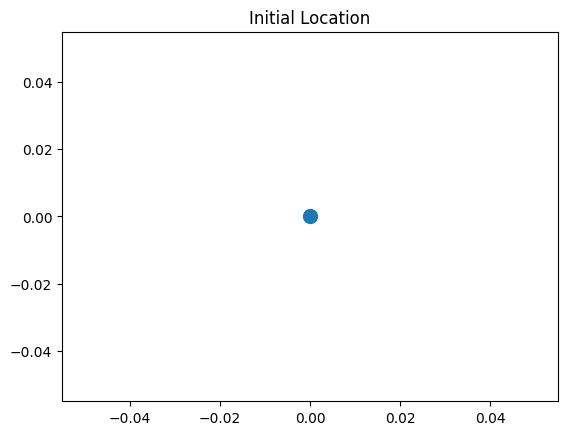

In [10]:
x = np.matrix([[0.0, 0.0, 0.0, 0.0]]).T
print(x, x.shape)
plt.scatter(float(x[0]),float(x[1]), s=100)
plt.title('Initial Location')

### Initial Uncertainty

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] (4, 4)


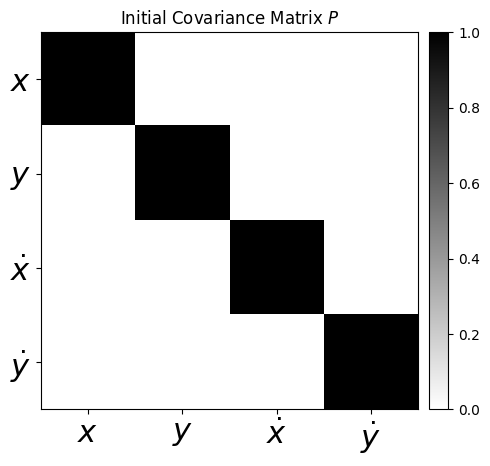

In [11]:
P = 1.0*np.eye(4)
print(P, P.shape)

fig = plt.figure(figsize=(5, 5))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Initial Covariance Matrix $P$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(5))
# set the locations and labels of the yticks
plt.yticks(np.arange(4),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(5))
# set the locations and labels of the yticks
plt.xticks(np.arange(4),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

plt.xlim([-0.5,3.5])
plt.ylim([3.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

### Dynamic Matrix

It is calculated from the dynamics of the Egomotion.

$$x_{k+1} = x_{k} + \dot x_{k} \cdot \Delta t$$
$$y_{k+1} = y_{k} + \dot y_{k} \cdot \Delta t$$
$$\dot x_{k+1} = \dot x_{k}$$
$$\dot y_{k+1} = \dot y_{k}$$

In [12]:
dt = 0.1 # Time Step between Filter Steps

A = np.matrix([[1.0, 0.0, dt, 0.0],
              [0.0, 1.0, 0.0, dt],
              [0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
print(A, A.shape)

[[1.  0.  0.1 0. ]
 [0.  1.  0.  0.1]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]] (4, 4)


### Measurement Matrix

We directly measure the Velocity $\dot x$ and $\dot y$

In [13]:
H = np.matrix([[0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
print(H, H.shape)

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]] (2, 4)


### Measurement Noise Covariance

R will be updated in each filter step in the adaptive Kalman Filter, here is just the initialization.

[[1. 0.]
 [0. 1.]] (2, 2)


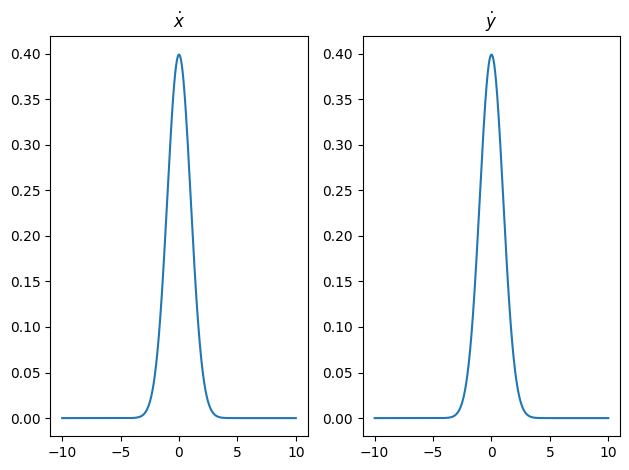

In [14]:
ra = 1.0**2

R = np.matrix([[ra, 0.0],
              [0.0, ra]])
print(R, R.shape)


# Plot between -10 and 10 with .001 steps.
xpdf = np.arange(-10, 10, 0.001)

plt.subplot(121)
plt.plot(xpdf, norm.pdf(xpdf,0,R[0,0]))
plt.title('$\dot x$')

plt.subplot(122)
plt.plot(xpdf, norm.pdf(xpdf,0,R[1,1]))
plt.title('$\dot y$')
plt.tight_layout()

### Process Noise Covariance

The Position of the car can be influenced by a force (e.g. wind), which leads to an acceleration disturbance (noise). This process noise has to be modeled with the process noise covariance matrix Q.

$$Q = \begin{bmatrix}\sigma_{x}^2 & \sigma_{xy} & \sigma_{x \dot x} & \sigma_{x \dot y} \\ \sigma_{yx} & \sigma_{y}^2 & \sigma_{y \dot x} & \sigma_{y \dot y} \\ \sigma_{\dot x x} & \sigma_{\dot x y} & \sigma_{\dot x}^2 & \sigma_{\dot x \dot y} \\ \sigma_{\dot y x} & \sigma_{\dot y y} & \sigma_{\dot y \dot x} & \sigma_{\dot y}^2 \end{bmatrix}$$

One can calculate Q as

$$Q = G\cdot G^T \cdot \sigma_v^2$$

with $G = \begin{bmatrix}0.5dt^2 & 0.5dt^2 & dt & dt\end{bmatrix}^T$ and $\sigma_v$ as the acceleration process noise.

In [15]:
sv = 1.0

G = np.matrix([[0.5*dt**2],
               [0.5*dt**2],
               [dt],
               [dt]])

Q = G*G.T*sv**2

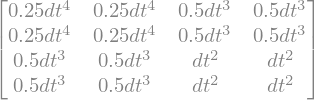

In [16]:
from sympy import Symbol, Matrix
from sympy.interactive import printing
printing.init_printing()
dts = Symbol('dt')
Qs = Matrix([[0.5*dts**2],[0.5*dts**2],[dts],[dts]])
Qs*Qs.T

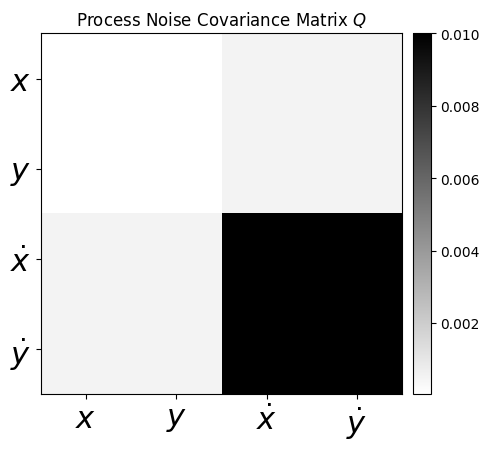

In [17]:
fig = plt.figure(figsize=(5, 5))
im = plt.imshow(Q, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Process Noise Covariance Matrix $Q$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(5))
# set the locations and labels of the yticks
plt.yticks(np.arange(4),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(5))
# set the locations and labels of the yticks
plt.xticks(np.arange(4),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

plt.xlim([-0.5,3.5])
plt.ylim([3.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

### Identity Matrix

In [18]:
I = np.eye(4)
print(I, I.shape)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] (4, 4)


## Measurement

In [19]:
m = 200 # Measurements
vx= 20 # in X
vy= 10 # in Y

mx = np.array(vx+np.random.randn(m))
my = np.array(vy+np.random.randn(m))

# some different error somewhere in the measurements
my[(m/2):(3*m/4)]= np.array(vy+20.0*np.random.randn(m/4))

measurements = np.vstack((mx,my))

print(measurements.shape)

TypeError: 'float' object cannot be interpreted as an integer

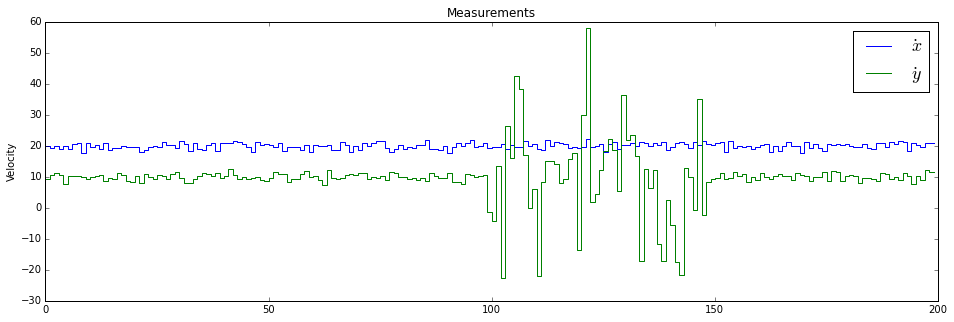

In [ ]:
fig = plt.figure(figsize=(16,5))

plt.step(range(m),mx, label='$\dot x$')
plt.step(range(m),my, label='$\dot y$')
plt.ylabel('Velocity')
plt.title('Measurements')
plt.legend(loc='best',prop={'size':18})

In [ ]:
# Preallocation for Plotting
xt = []
yt = []
dxt= []
dyt= []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Rdx= []
Rdy= []
Kx = []
Ky = []
Kdx= []
Kdy= []

# Kalman Filter

![Kalman Filter](https://raw.github.com/balzer82/Kalman/master/Kalman-Filter-Step.png)

In [ ]:
for n in range(len(measurements[0])):
    
    # Adaptive Measurement Covariance R from last i Measurements
    # as an Maximum Likelihood Estimation
    i = 10
    if n>i:
        R = np.matrix([[np.std(measurements[0,(n-i):n])**2, 0.0],
                      [0.0, np.std(measurements[1,(n-i):n])**2]])
    
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = A*x
    
    # Project the error covariance ahead
    P = A*P*A.T + Q
    
    
    # Measurement Update (Correction)
    # ===============================
    # Compute the Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)

    
    # Update the estimate via z
    Z = measurements[:,n].reshape(2,1)
    y = Z - (H*x)                            # Innovation or Residual
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*H))*P


    
    
    # Save states for Plotting
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    dxt.append(float(x[2]))
    dyt.append(float(x[3]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Rdx.append(float(R[0,0]))
    Rdy.append(float(R[1,1]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))    

Thats it.

# Let's take a look at the filter performance

### Kalman Gains K

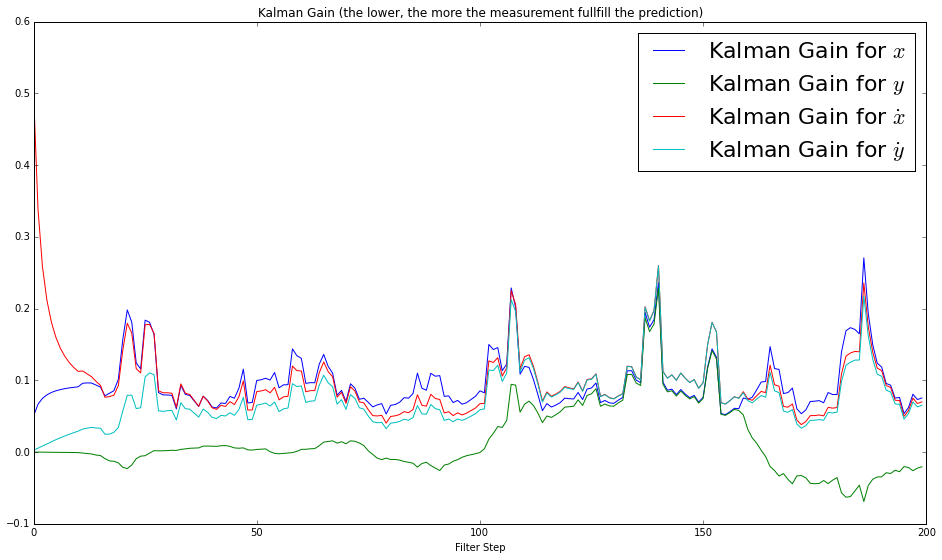

In [ ]:
fig = plt.figure(figsize=(16,9))
plt.plot(range(len(measurements[0])),Kx, label='Kalman Gain for $x$')
plt.plot(range(len(measurements[0])),Ky, label='Kalman Gain for $y$')
plt.plot(range(len(measurements[0])),Kdx, label='Kalman Gain for $\dot x$')
plt.plot(range(len(measurements[0])),Kdy, label='Kalman Gain for $\dot y$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
plt.legend(loc='best',prop={'size':22})

### Covariance Matrix

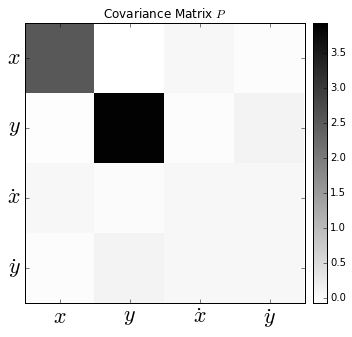

In [ ]:
fig = plt.figure(figsize=(5, 5))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Covariance Matrix $P$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(5))
# set the locations and labels of the yticks
plt.yticks(np.arange(4),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(5))
# set the locations and labels of the yticks
plt.xticks(np.arange(4),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

plt.xlim([-0.5,3.5])
plt.ylim([3.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

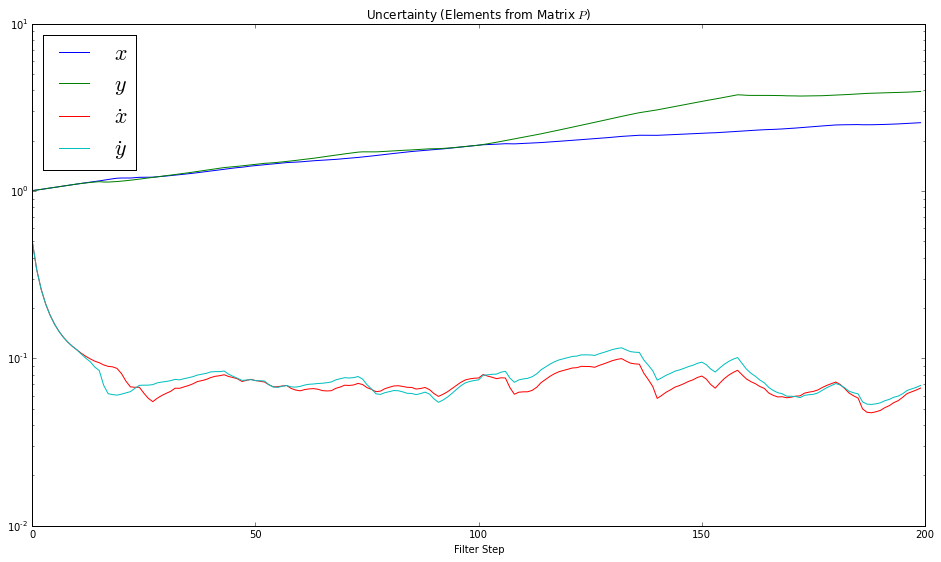

In [ ]:
fig = plt.figure(figsize=(16,9))
plt.semilogy(range(len(measurements[0])),Px, label='$x$')
plt.semilogy(range(len(measurements[0])),Py, label='$y$')
plt.semilogy(range(len(measurements[0])),Pdx, label='$\dot x$')
plt.semilogy(range(len(measurements[0])),Pdy, label='$\dot y$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Uncertainty (Elements from Matrix $P$)')
plt.legend(loc='best',prop={'size':22})

### State Estimate

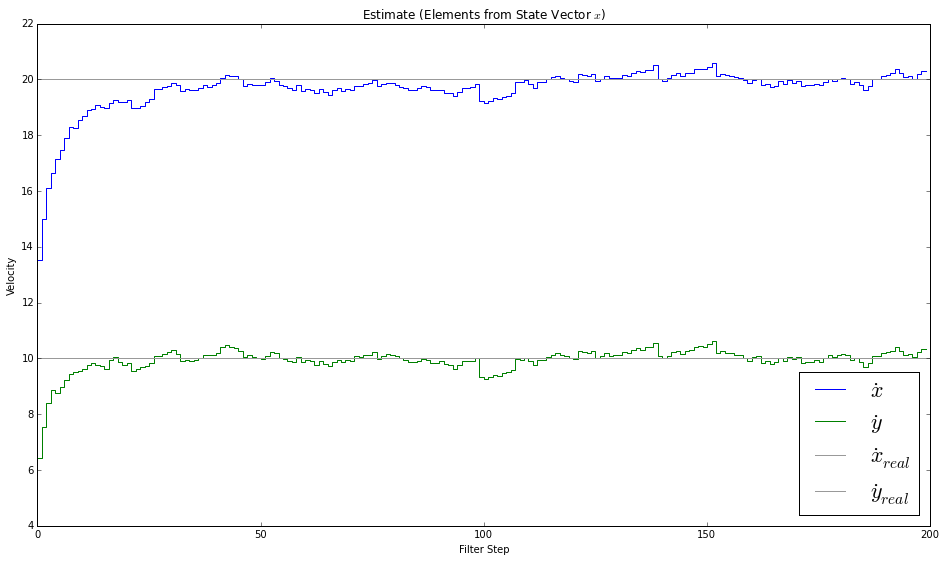

In [ ]:
fig = plt.figure(figsize=(16,9))
plt.step(range(len(measurements[0])),dxt, label='$\dot x$')
plt.step(range(len(measurements[0])),dyt, label='$\dot y$')

plt.axhline(vx, color='#999999', label='$\dot x_{real}$')
plt.axhline(vy, color='#999999', label='$\dot y_{real}$')

plt.xlabel('Filter Step')
plt.title('Estimate (Elements from State Vector $x$)')
plt.legend(loc='best',prop={'size':22})
plt.ylabel('Velocity')

### Measurement Uncertainty R

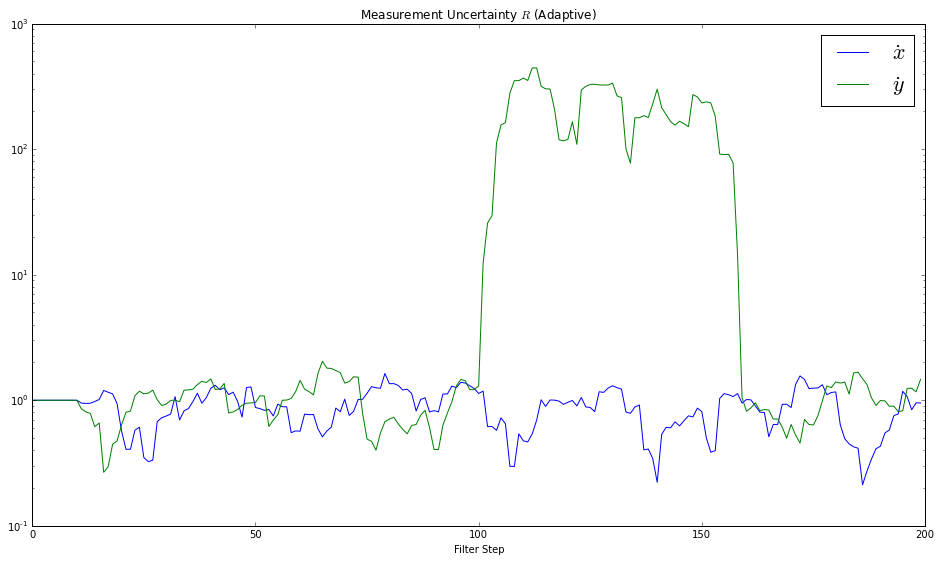

In [ ]:
fig = plt.figure(figsize=(16,9))
plt.semilogy(range(len(measurements[0])),Rdx, label='$\dot x$')
plt.semilogy(range(len(measurements[0])),Rdy, label='$\dot y$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Measurement Uncertainty $R$ (Adaptive)')
plt.legend(loc='best',prop={'size':22})

## Position x/y

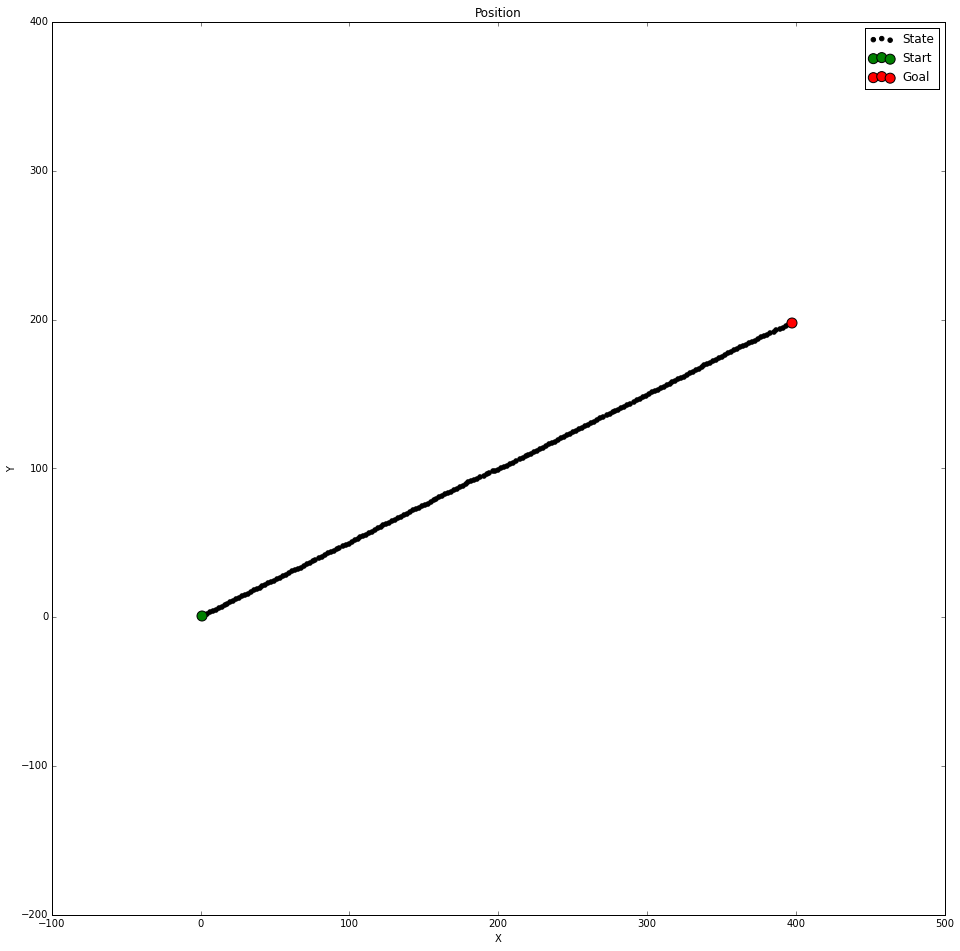

In [ ]:
fig = plt.figure(figsize=(16,16))
plt.scatter(xt,yt, s=20, label='State', c='k')
plt.scatter(xt[0],yt[0], s=100, label='Start', c='g')
plt.scatter(xt[-1],yt[-1], s=100, label='Goal', c='r')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Position')
plt.legend(loc='best')
plt.axis('equal')

# Conclusion

As you can see, between Filter Step 100 and 150 you have massive noise in the measurement, but the adaptive filter is raising the measurement covariance (R), so that the Kalman Gain is tryin to use the dynamic of the model instead of the measurement.